<!-- Assignment 2 - SS 2023 -->

# Vision Networks and Fast Training (15 points)

This notebook contains one of the assignments for the exercises in Deep Learning and Neural Nets 2.
It provides a skeleton, i.e. code with gaps, that will be filled out by you in different exercises.
All exercise descriptions are visually annotated by a vertical bar on the left and some extra indentation,
unless you already messed with your jupyter notebook configuration.
Any questions that are not part of the exercise statement do not need to be answered,
but should rather be interpreted as triggers to guide your thought process.

**Note**: The cells in the introductory part (before the first subtitle)
perform all necessary imports and provide utility functions that should work without (too much) problems.
Please, do not alter this code or add extra import statements in your submission, unless explicitly allowed!

<span style="color:#d95c4c">**IMPORTANT:**</span> Please, change the name of your submission file so that it contains your student ID!

In this assignment, we will take a closer look at some famous vision architectures.
Since most of these architectures are very large, it requires high-end hardware to train from scratch.
To leverage the limited availability of hardware, also *Transfer Learning* can be used.
By using stored weights of a large network a new network can be trained cheaply on new datasets.

In [ ]:
import inspect
import torch
import torchvision
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm.notebook import trange

torch.manual_seed(1806)
torch.cuda.manual_seed(1806)

In [ ]:
# google colab data management
import os.path

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    _home = 'gdrive/MyDrive/'
except ImportError:
    _home = '~'
finally:
    data_root = os.path.join(_home, '.pytorch')

print(data_root)

~/.pytorch


## LeNet-5 and its Offspring

![LeNet-5 architecture](https://miro.medium.com/max/2154/1*1TI1aGBZ4dybR6__DI9dzA.png)

The LeNet-5 architecture (depicted above) is one of the first convolutional networks.
Since convolutions are extremely well suited for many computer vision tasks,
a wide variety of network architectures using convolutional layers has become available.
Although the differences in performance are sometimes large,
the architectures can generally be considered variations on the same theme.

### Alexnet

![alex-net architecture](https://cdn-images-1.medium.com/max/1000/1*wzflNwJw9QkjWWvTosXhNw.png)

In 2012 Alex Krizhevsky et al. won the [Imagenet Large Scale Visual Recognition Challenge](http://www.image-net.org/challenges/LSVRC/) (ILSVRC).
The network they used, which is known as *Alex-net*, is depicted below and follows the same basic principles as LeNet-5.
Alex-net has quite a bit more parameters than LeNet-5, therefore it requires a large amount of computational resources to train.

To speed up training time, Alex-net was trained on GPU.
Since GPUs have access to little memory compared to CPUs (especially back in the days),
alex-net did not fit on a single GPU and required 2 GPUs to train the model,
hence the distinction between two paths in the illustration of the network.

On modern GPUs, it is no longer a problem to fit alex-net on a single GPU.
Due to the fact that deep learning frameworks mostly support hardware acceleration,
it has even become extremely easy and almost common to train (large) networks on GPUs.
A more detailed description on how to achieve this in pytorch, is given below.

Another important add-on, is the use of the dropout regularisation technique in the fully connected layers.
From DL & NN 1 you should remember that dropout behaves differently during testing and training.
When using Dropout or other modules with different behaviour, e.g. BatchNorm, in pytorch,
it is important to make sure that your network operates in the right mode.
To do this, the `nn.Module` class provides the `train` and `eval` methods
and invokes it on all submodules to assure that the desired behaviour is triggered.

### Pytorch GPU acceleration

In pytorch, training a model on GPU is relatively easy.
To copy a tensor `x` from main memory (or wherever it may be) to GPU memory,
all we need to do is call `x.to('cuda')` or equivalently `x.cuda()`.
When multiple GPUs are available, `x.to('cuda:0')` copies a tensor to the first GPU,
`x.to('cuda:1')` to the second, etc.
Similarly, to copy a tensor from a GPU (or again wherever it may be) to main memory,
`x.to('cpu')` or equivalently `x.cpu()` can be used.

Whenever a computation is done on tensors that reside on a specific device,
the result will also be on that device.
It is not possible, however, to make computations with tensors from different devices.
This means that the training of an entire network automatically takes place on e.g. a GPU,
as soon as all the variables reside on the same device.
When working with neural networks,
this is the case if both the network parameters and the data are moved to the same device.

To move all parameters of a network to the correct device,
The `nn.Module` class provides a convenience `to` method
that moves all registered parameters, buffers and submodules to the correct device.

As for the data, it is often possible to fit the entire dataset in GPU memory.
However, often it does not provide any advantages or it even comes with disadvantages.
E.g. the `MNIST` dataset from `torchvision` provides PIL images that can not reside on GPU.
If the dataset would be stored on the GPU, the data would have to move to CPU first,
where the pre-processing is done on the PIL images, and then move back to the GPU.
Therefore, it is considered good practice to keep the dataset in main memory
and move the samples to the GPU only when they are needed for computation.

### Exercise 1: Hardware Acceleration (3 points)

In order to allow our computations to be accelerated,
the utility functions `evaluate` and `update` require some minor adjustments.

 > Alter the `evaluate` and `update` functions from assignment 1
 > so that it is assured that the inputs are on the same device as the network parameters.
 > Also put the networks in the right modes so that dropout etc. work correctly.

In [ ]:
@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> list:
    # YOUR CODE HERE
    #raise NotImplementedError()

    network.eval()
    device = next(network.parameters()).device

    metrics = []
    with torch.no_grad():
      for inputs,targets in data:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = network(inputs)
        error = metric(outputs, targets.long())
        metrics.append(error.item())

    return metrics




@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module,
           opt: optim.Optimizer) -> list:
    # YOUR CODE HERE
    #raise NotImplementedError()

    network.train()
    device = next(network.parameters()).device

    losses = []
    for inputs,targets in data:
      inputs = inputs.to(device)
      targets = targets.to(device)
      opt.zero_grad()
      outputs = network(inputs)

      error = loss(outputs, targets.long())
      losses.append(error.item())
      error.backward()
      opt.step()

    return losses

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

### VGG

<img src="https://miro.medium.com/max/2628/1*lZTWFT36PXsZZK3HjZ3jFQ.png"
     alt="VGG architecture" style="width: 70%; margin: auto" />

The Visual Geometry Group at Oxford University introduced
different versions of architectures that are now known as VGG net.
11-layer, 16-layer and 19-layer variants exist,
all of which use only 3x3 convolutions in the feature extraction part.

After winning the Imagenet Large Scale Visual Recognition Challenge (ILSVRC) in 2014,
the weights of the winning models were made [available](https://www.robots.ox.ac.uk/~vgg/research/very_deep/).
This made it possible for researchers with lower computational budgets
to make use of the features the network has extracted for natural images.
Since 2021, large pre-trained models often end up serving as [foundation models](https://en.wikipedia.org/wiki/Foundation_models).
Note that VGG is a very small model compared to modern "large" models today.

### Exercise 2: VGG for CIFAR-10 (2 points)

Most vision architectures have been trained on the ImageNet dataset, which is hard to come by:
it is very large (a few 100GB) and requires registration to get access to the images.
[CIFAR-10 and CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html)
are similar datasets that are much easier to obtain
and they are one of the standard datasets in `torchvision.datasets`.
In this exercise the goal is to modify a vision network that was trained on ImageNet
to make predictions on CIFAR-10 so that we can reuse large parts of the weights.

 > Create a network with the same feature extraction architecture as
 > `torchvision.models.VGG` so that it can be used for CIFAR images.
 > Concretely, the goal is to replace the classifier to predict CIFAR labels
 > instead of the Imagenet labels.
 > Use global average pooling to make the classifier independent of the exact image size.
 > Keep the classifier architecture rectangular, i.e. same width for all layers (except for the classes).

**Hint:** Take a look at [`torchvision.models.VGG`](https://pytorch.org/vision/0.13/_modules/torchvision/models/vgg.html) if you need some inspiration.

In [ ]:
class CifarVGG(nn.Module):
    """ Variant of the VGG network for classifying CIFAR images. """

    def __init__(self, features: nn.Module, num_classes: int = 10):
        """
        Parameters
        ----------
        features : nn.Module
            The convolutional part of the VGG network.
        num_classes : int
            The number of output classes in the data.
        """
        # YOUR CODE HERE
        # raise NotImplementedError()
        super().__init__()
        self.features = features
        for parameter in self.features.parameters():
          parameter.requires_grad = False

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),  # Keep the classifier architecture rectangular
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes),
        )


    def forward(self, x: torch.Tensor) :
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

### Exercise 3: Existing Features (2 points)

Training a network like VGG (or any of the other networks in this assignment)
can take a few hours when training on a GPU.
Therefore it is often useful to be able to load pre-trained weights into the network.
Also, saving a model that has been trained for hours can often save a lot of time.
In pytorch this is possible through what is called
[`state_dict`s](https://pytorch.org/tutorials/beginner/saving_loading_models.html).
Saving the parameters of a pytorch module can be done with `torch.save(module.state_dict(), path)`,
whereas loading saved parameters is done with `module.load_state_dict(torch.load(path))`.

 > Write a function `vgg_init_` to initialise a `CifarVGG` network.
 > It should load the pre-trained weights for the **11-layer variant of VGG** from `torchvision.models.vgg`
 > to initialise the feature extractor of the model
 > and reasonably initialise the classifier using initialisation functions from `torch.nn.init`.

**Hint:** you can use all of the functions available in `torchvision.models.vgg`.

In [ ]:
def vgg_init_(network: CifarVGG):
    """
    Initialise a CifarVGG network with a pre-trained VGG feature extractor.

    Parameters
    ----------
    network : CifarVGG
        The model to initialise.
    """
    from torchvision.models import vgg
    # YOUR CODE HERE
    #raise NotImplementedError()

    weights = vgg.VGG11_Weights.DEFAULT.get_state_dict(progress=True)
    pretrained_weights = {k:val for k, val in weights.items() if "features" in k and '.0.' not in k}
    network.features.load_state_dict(pretrained_weights, strict=False)

    # Initialise the classifier layers
    for layer in network.classifier.modules():
        if isinstance(layer, nn.Linear):
            torch.nn.init.kaiming_normal_(layer.weight)
            torch.nn.init.zeros_(layer.bias)

In [ ]:
# sanity check
vgg11 = torchvision.models.vgg11()
network = CifarVGG(vgg11.features, num_classes=10)
vgg_init_(network)

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

### Exercise 4: Training (part of) the Network (4 points)

Obviously, a classifier for CIFAR 10 will be different from a classifier for Imagenet.
With the initialisation above, the `CifarVGG` has a ready-to-go feature extractor,
but the classifier part still has to be trained.
To do this training efficiently, there are a few things left to do.

 > The code below should train the entire network on the entire dataset for a few epochs.
 > Modify the code so that
 > 1. it only trains the classifier part of the network using SGD
 > and leaves the convolutional feature extractor untouched, i.e., *frozen*.
 > 2. the 32x32 CIFAR images are upscaled to 224x224 pixels.
 > 3. training is done on the GPU, which is generally faster.
 > 4. it uses a parallel dataloader to make sure that the GPU does not have to wait for data.
 > 5. only a random subset of 500 images from the CIFAR data is used for training.
 > 6. a random subset of 500 images from the CIFAR data is used as validation data.
 > You will also need to include a round of validation in the training loop.
 > This should give you some confidence that the classifier is learning something useful.

**Hint:** you might find useful tools under
[`torch.utils.data`](https://pytorch.org/docs/stable/data.html).

In [ ]:
def get_cifar10(root: str, batch_size: int = 32, resize: tuple[int, int] = (224, 224),
                num_train: int = 500, num_valid: int = 500, num_workers: int = 4):
    """
    Get dataloader(s) for CIFAR-10.

    Parameters
    ----------
    root : str
        Path to directory where CIFAR-10 dataset is stored.
    batch_size : int, optional
        The number of samples per mini-batch.
    resize : tuple of int, optional
        Desired width and height of loaded images.
    num_train : int, optional
        Number of (random) samples to use for training.
    num_valid : int, optional
        Number of (random) samples to use for validation.
    num_workers : int, optional
        Number of parallel processes to use for loading data.

    Returns
    -------
    train_batches : DataLoader
        A dataloader that loads mini-batches of CIFAR-10 for training.
    valid_batches : DataLoader
        A dataloader that loads (mini-)batches of CIFAR-10 for validation.
    """
    normalise=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])
    cifar10 = torchvision.datasets.CIFAR10(root, transform=normalise, download=True)
    train_batches = DataLoader(cifar10, batch_size=batch_size)
    # YOUR CODE HERE
    #raise NotImplementedError()

    train_data, valid_data, _ = torch.utils.data.random_split(cifar10,[num_train, num_valid, len(cifar10) -num_train - num_valid])

    train_batches = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_batches = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)

    return train_batches, valid_batches

In [ ]:
# Test Cell: do not edit or delete!
train_batches, valid_batches = get_cifar10(data_root)

Files already downloaded and verified


In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
def get_vgg(num_classes: int = 10, device: str = "cpu"):
    """
    Create and initialise VGG network on given device.

    Parameters
    ----------
    num_classes : int, optional
        The number of output units for the network.
    device : str, optional
        A string representing the device to work on
    """
    vgg11 = torchvision.models.vgg11()
    net = CifarVGG(vgg11.features, num_classes=10)
    vgg_init_(net)
    # YOUR CODE HERE
    # raise NotImplementedError()
    net.to(device)
    return net

In [ ]:
# Test Cell: do not edit or delete!
network = get_vgg(device='cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class TransferTrainer:

    def __init__(self, model: nn.Module):
        """
        Create a trainer for transfer learning.

        Parameters
        ----------
        model : nn.Module
            The model to train.
        """
        self.model = model
        self.objective = nn.CrossEntropyLoss(reduction="sum")
        self.optimiser = None
        # YOUR CODE HERE
        #raise NotImplementedError()

        self.params_to_update = []
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.params_to_update.append(param)

        # Initialise optimiser with trainable parameters
        self.optimiser = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)



    def train(self, train_batches: DataLoader, valid_batches: DataLoader,
              num_epochs: int = 1):
        """
        Train (part of) the network for a number of epochs.

        Parameters
        ----------
        train_batches : DataLoader
            The training data for updating the network.
        valid_batches : DataLoader
            The validation data for evaluating the network.
        num_epochs : int, optional
            The number of iterations over the training data.
        """
        train_errs, valid_errs = [], []
        for _ in trange(num_epochs):
            local_errs = update(self.model, train_batches, self.objective, self.optimiser)
            train_errs.append(sum(local_errs) / len(local_errs) / train_batches.batch_size)
            # YOUR CODE HERE
            #raise NotImplementedError()

            # Evaluate on validation set
            valid_err = evaluate(self.model, valid_batches, self.objective)
            valid_err = round(sum(valid_err) / len(valid_err) / train_batches.batch_size, 2)
            valid_errs.append(valid_err)

        return train_errs, valid_errs

In [ ]:
trainer = TransferTrainer(network)
train_errs, valid_errs = trainer.train(train_batches, valid_batches, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

ran on cpu


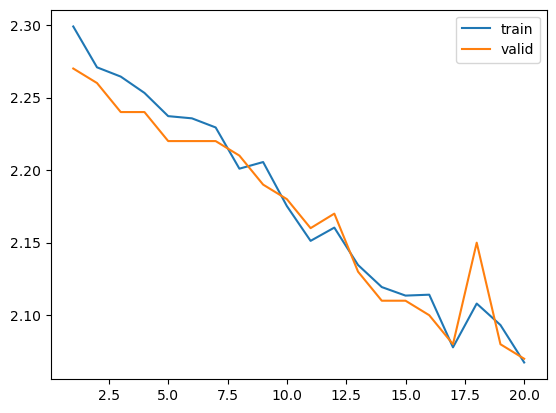

In [ ]:
# plot learning curves
from matplotlib import pyplot as plt
plt.plot(range(1, len(train_errs) + 1), train_errs, label="train")
plt.plot(range(1, len(valid_errs) + 1), valid_errs, label="valid")
plt.legend()
print(f"ran on {next(network.parameters()).device}")

## Skip-connections

One of the most popular modern network architectures for vision is the residual network.
The main feature of this architecture is the so-called skip-connection,
which allows to combine the activations with the original inputs in each layer.
Since these skip-connections open up a gradient highway,
they make it possible to train much deeper networks than is possible without the skip-connections.

Mathematically, the simplest form of a skip connection can be written as
$$\boldsymbol{s} = \boldsymbol{x} + f(\boldsymbol{x}).$$
In order for this to work, the dimensions of $\boldsymbol{x}$ and $f(\boldsymbol{x})$ must line up.
This means that in this formulation, only square layers,
i.e. layers with the same number of inputs and outputs, are possible.

In order to use a skip-connection on layers that reduce the dimensionality,
a linear transform on $\boldsymbol{x}$ can be inserted in the equation.
Since also other operations are possible, on both inputs and (pre-)activations,
we can generalise the skip-connection formula to
$$\boldsymbol{s} = \boldsymbol{C} \cdot \boldsymbol{x} + \boldsymbol{T} \cdot f(\boldsymbol{x}),$$
where $\boldsymbol{C}$ and $\boldsymbol{T}$ are linear transformations (a.k.a. matrices).

### Exercise 5: Pre-Residual Networks (4 points)

The original and most commonly used residual networks actually do not implement skip connections as in the formula above.
Upon closer inspection (e.g. `torchvision.models.resnet`), it becomes clear that the most famous skip-connection looks more like

$$\boldsymbol{a} = \phi(\boldsymbol{x} + f(\boldsymbol{x})),$$

where $\phi$ is some non-linear activation function.
This non-linearity typically interferes with the signal propagation of the network.
As a result, gradients might still vanish despite the skip-connection.

Pre-Residual Networks aim to counter this problem by moving skip-connections to the level of pre-activations, such that

$$\boldsymbol{a} = \boldsymbol{x} + f(\phi(\boldsymbol{x})).$$

This way, clean signal propagation can be guaranteed and learning should become easier.

 > Implement the `PreResBlock` class so that it can be used as a layer in a pre-residual network.
 > The residual part of the network, $f$, should be a small network with two convolutional layers.
 > Both layers should use the given `kernel_size` and preserve the image size if `stride` is one.
 > If `stride` is greater than one, the network should reduce the spatial dimensions by this factor.
 > Make sure that the network also works if `in_channels != out_channels` and `stride > 1`.
 > Try to avoid unnecessary parameters, especially for the skip-connection.

In [ ]:
class PreResBlock(nn.Module):
    """ Residual block using skip-connections on pre-activation level. """

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3,
                 stride: int = 1, phi: nn.Module = nn.ReLU(), extra_pars: bool = True):
        """
        Parameters
        ----------
        in_channels : int
            Number of input channels.
        out_channels : int
            Number of output channels.
        kernel_size : int
            Size of the kernel in all dimensions.
        stride : int
            Factor by which to reduce the spatial dimensions.
        phi : nn.Module
            The activation function to use in the residual branch.
        """
        super().__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()

        padding = kernel_size // 2

        # Residual function f
        self.f = nn.Sequential(
            phi,
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            phi,
            nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Skip connection
        if in_channels != out_channels or stride > 1:
            self.adjust_channels = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.adjust_channels = None




    def forward(self, x):
        out = self.f(x)
        x = self.adjust_channels(x) if self.adjust_channels else x
        out = out + x

        return out


In [ ]:
# Test Cell: do not edit or delete!
block = PreResBlock(8, 8)
out = block(torch.zeros(1, 8, 32, 32))
sum(par.numel() for par in block.parameters()), out.shape

(1184, torch.Size([1, 8, 32, 32]))

In [ ]:
# Test Cell: do not edit or delete!
strided_block = PreResBlock(8, 8, stride=2)
out = strided_block(torch.zeros(1, 8, 32, 32))
sum(par.numel() for par in strided_block.parameters()), out.shape

(1264, torch.Size([1, 8, 16, 16]))

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!